# Imports

In [1]:
from fastai import *
from fastai.vision import *
import re
import os.path

# Data Gathering

Using CTRL-SHIFT-K to open the browser console, and then posting in this:

`urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));`

will generate CSV files with all the addresses of the images to download. Save these files in `csv_path`, and designate a `data_path` where the images will be stored. 

In [2]:
data_path = Path('/media/andrew/Data/BirdsofAL')
csv_path = Path('/home/andrew/Code/repos/BirdsofAL/image_csvs')
#Path??

# Setup
### Only needs to be performed one time

In [3]:
classes = []

In [4]:
csv_path.ls()

[PosixPath('/home/andrew/Code/repos/BirdsofAL/image_csvs/Summer_Tanager.csv'),
 PosixPath('/home/andrew/Code/repos/BirdsofAL/image_csvs/Barn_Swallow.csv'),
 PosixPath('/home/andrew/Code/repos/BirdsofAL/image_csvs/Eastern_Bluebird.csv'),
 PosixPath('/home/andrew/Code/repos/BirdsofAL/image_csvs/Brown_Pelican.csv'),
 PosixPath('/home/andrew/Code/repos/BirdsofAL/image_csvs/American_Robin.csv'),
 PosixPath('/home/andrew/Code/repos/BirdsofAL/image_csvs/American_Goldfinch.csv'),
 PosixPath('/home/andrew/Code/repos/BirdsofAL/image_csvs/Northern_Cardinal.csv'),
 PosixPath('/home/andrew/Code/repos/BirdsofAL/image_csvs/Cedar_Waxwing.csv'),
 PosixPath('/home/andrew/Code/repos/BirdsofAL/image_csvs/Bald_Eagle.csv'),
 PosixPath('/home/andrew/Code/repos/BirdsofAL/image_csvs/Blue_Jay.csv'),
 PosixPath('/home/andrew/Code/repos/BirdsofAL/image_csvs/Great_Blue_Heron.csv'),
 PosixPath('/home/andrew/Code/repos/BirdsofAL/image_csvs/Red-winged_Blackbird.csv'),
 PosixPath('/home/andrew/Code/repos/BirdsofAL/ima

In [5]:
# # make all folders and download all pictures
# # Note: don't need to rerun if already run
for file in csv_path.iterdir():
    file = os.path.basename(file)
    clas = file.rstrip(".csv")
    classes.append(clas)
#     dest = data_path/clas
#     dest.mkdir(parents=True, exist_ok=True)
#     download_images(csv_path/file, dest, max_pics=200)

In [6]:
classes

['Summer_Tanager',
 'Barn_Swallow',
 'Eastern_Bluebird',
 'Brown_Pelican',
 'American_Robin',
 'American_Goldfinch',
 'Northern_Cardinal',
 'Cedar_Waxwing',
 'Bald_Eagle',
 'Blue_Jay',
 'Great_Blue_Heron',
 'Red-winged_Blackbird',
 'Killdeer',
 'Barred_Owl',
 'Indigo_Bunting',
 'White-breasted_Nuthatch',
 'Brown_Headed_Nuthatch',
 'American_Crow',
 'Hooded_Warbler',
 'Northern_Mockingbird',
 'Carolina_Chickadee']

In [7]:
for c in classes:
    verify_images(data_path/c, delete=True, max_size=500)

# View Data

In [8]:
np.random.seed(1)
data = ImageDataBunch.from_folder(path=data_path, valid_pct=0.2, 
                                  ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [9]:
# If you already cleaned your data, run this cell instead of the one before
# np.random.seed(1)
# data = ImageDataBunch.from_csv(".", folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
#                                 ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [10]:
data.c

21

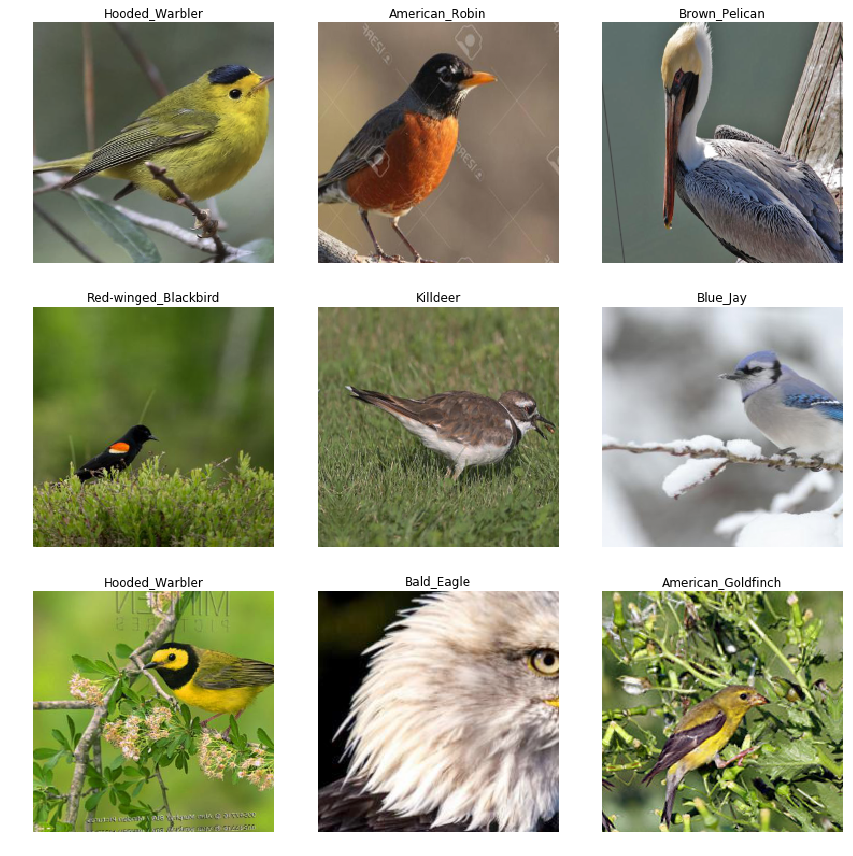

In [11]:
data.show_batch(rows=3)

In [12]:
print(" Training dataset size:", len(data.train_ds), '\n', "Validation dataset size:", len(data.valid_ds))

 Training dataset size: 2621 
 Validation dataset size: 655


# Create CNN & Begin Training

In [13]:
learn = create_cnn(data, models.resnet34, metrics=accuracy)

In [14]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy
1,1.865320,0.377329,0.909924
2,0.855696,0.249609,0.926718
3,0.495196,0.219276,0.938931
4,0.331740,0.211463,0.940458


In [15]:
learn.save('stage-1')

In [16]:
learn.unfreeze()

In [17]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


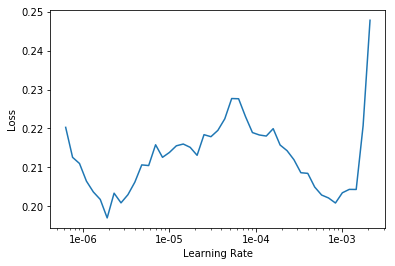

In [18]:
learn.recorder.plot()

# Continue Training

In [19]:
learn.freeze()

In [20]:
learn.fit_one_cycle(2, max_lr=slice(6e-4, 1e-4))

epoch,train_loss,valid_loss,accuracy
1,0.197797,0.204030,0.945038
2,0.198832,0.205903,0.941985


In [21]:
learn.fit_one_cycle(5, max_lr=slice(3e-4, 1e-4))

epoch,train_loss,valid_loss,accuracy
1,0.196168,0.205398,0.941985
2,0.188303,0.198832,0.946565
3,0.176327,0.196711,0.948092
4,0.169356,0.192943,0.949618
5,0.166476,0.197571,0.949618


In [22]:
learn.save('stage-2')

It seems like we are getting a little closer to having a good model. Let's to check what our bad actors are.

# Interpretation

In [23]:
interp = ClassificationInterpretation.from_learner(learn)

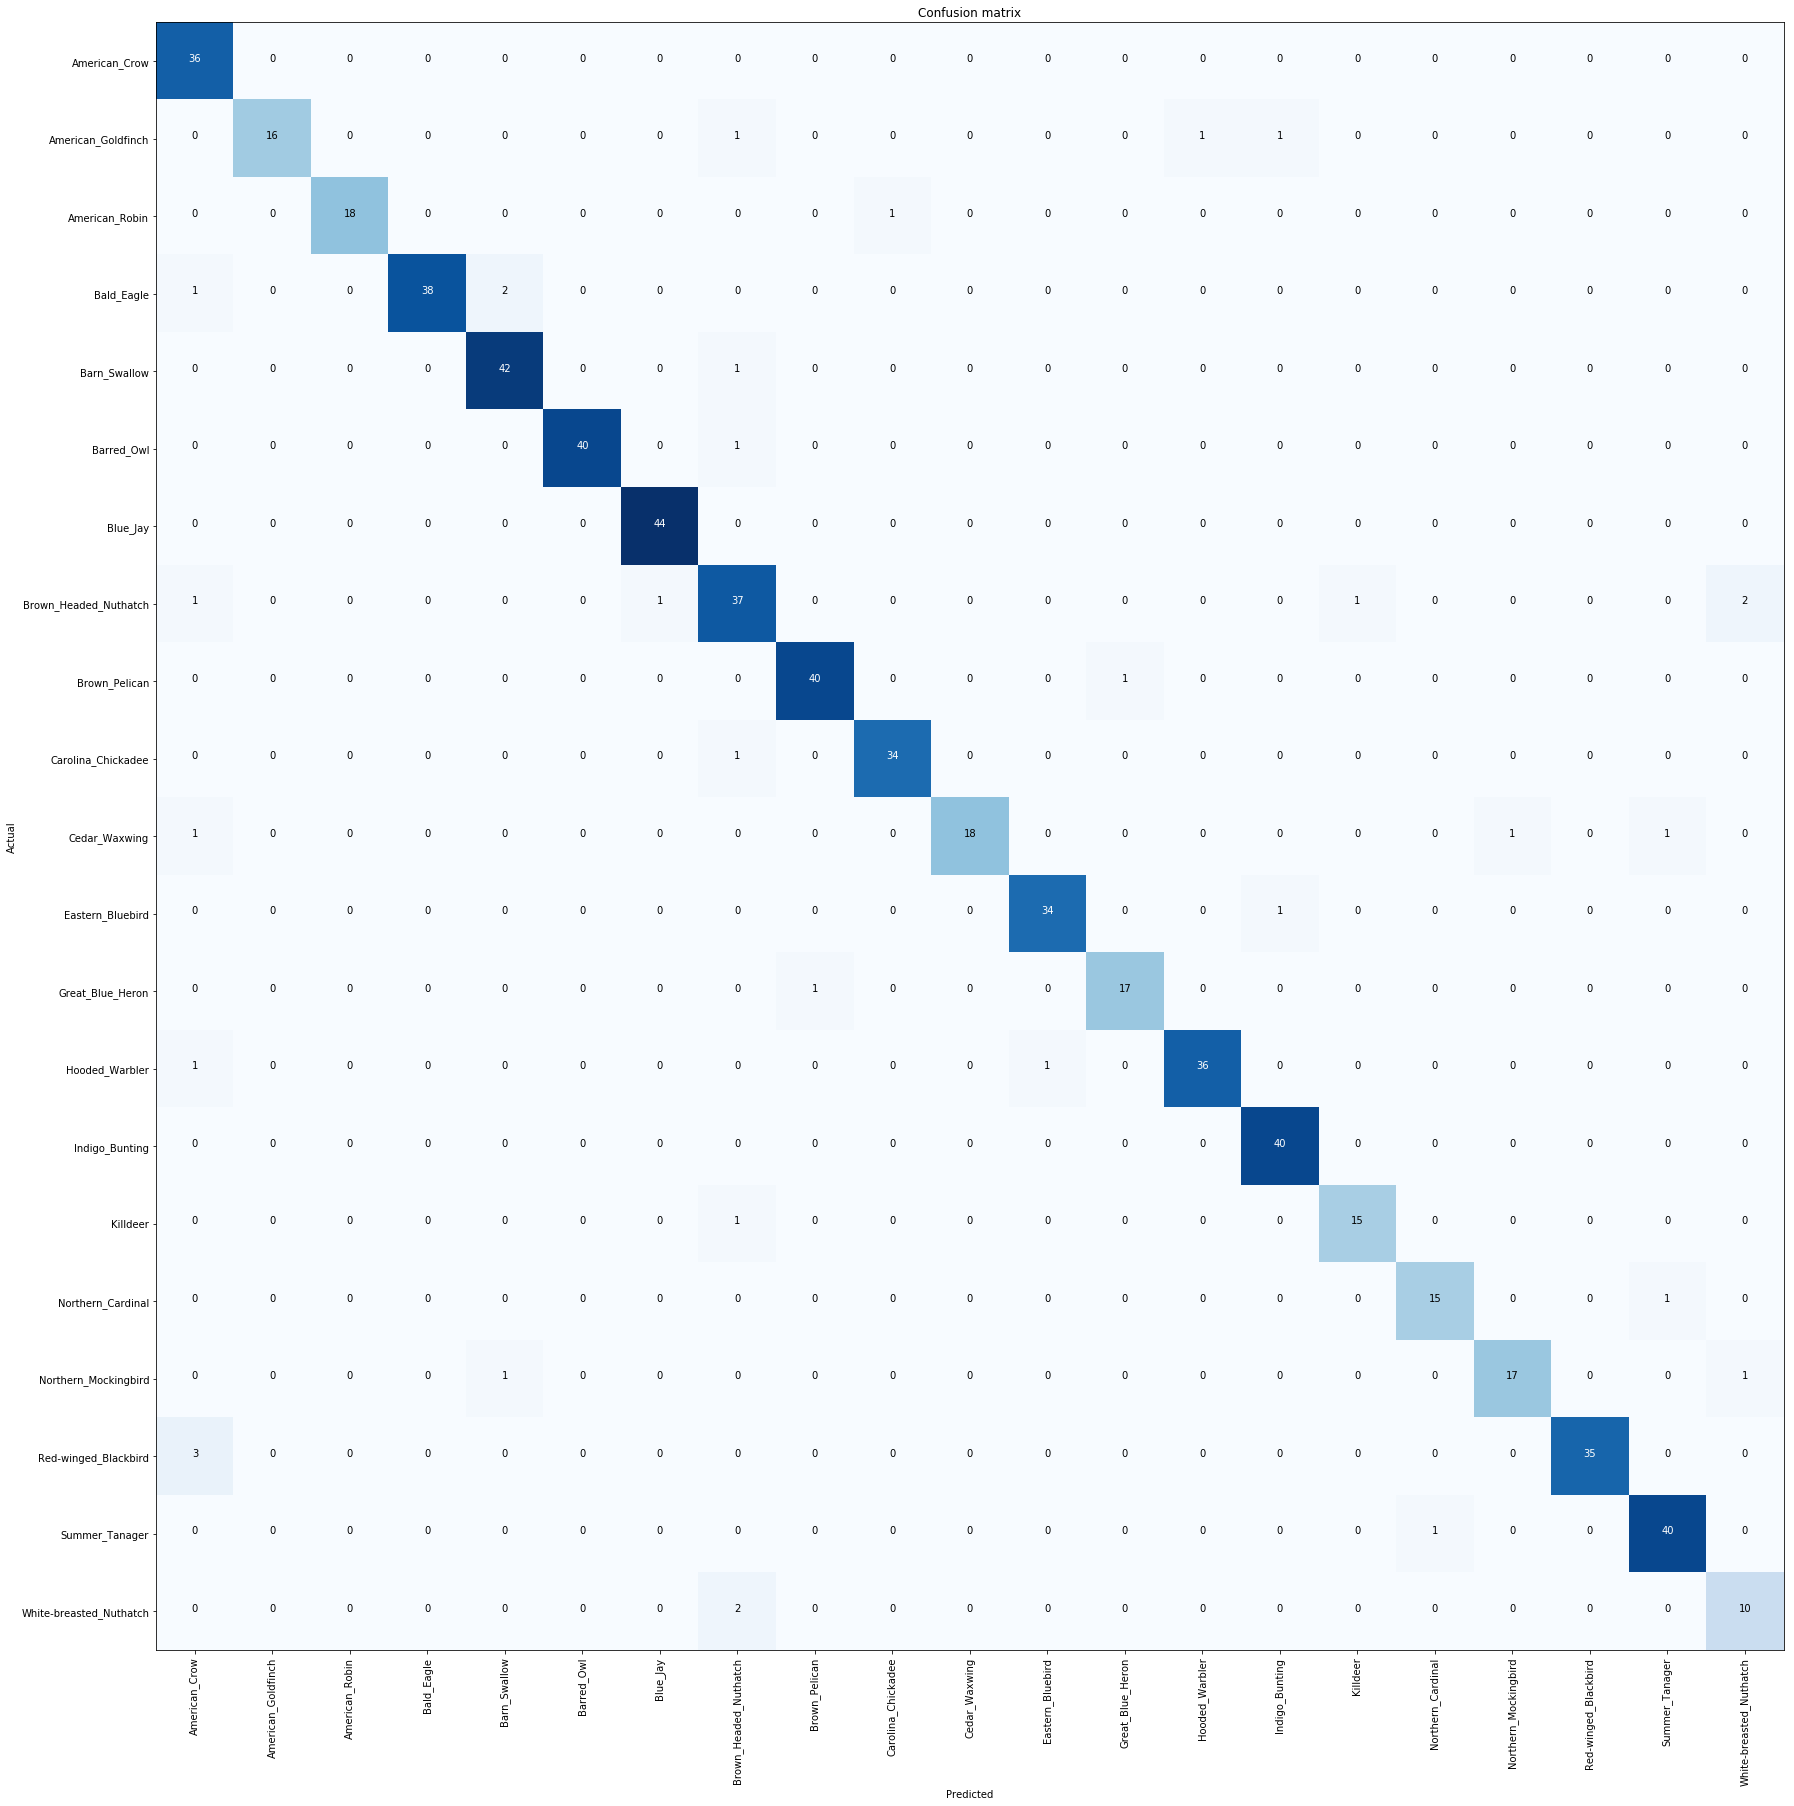

In [24]:
interp.plot_confusion_matrix(figsize=(25,25))

It seems like the system generally does well. One of the largest mistakes made is confusing Red winged blackbirds for American Crows. 

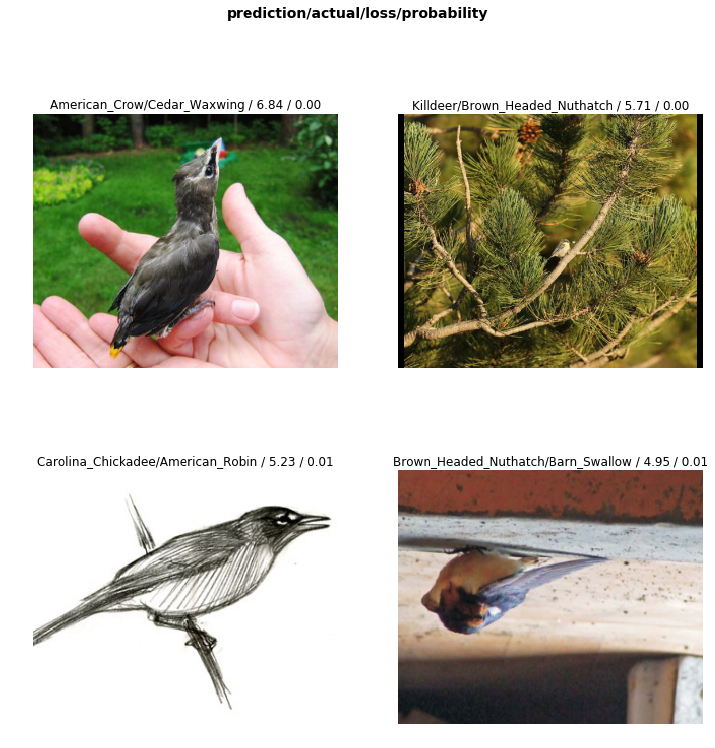

In [67]:
interp.plot_top_losses(4)

Let's analyze these mistakes:
1. It predicted American Crow, whereas the real bird is a Cedar Waxwing. Those two birds look nothing alike, so it is good that the probability of American Crow is essentially 0. Typically the pictures used show the bird looking much more majestic. The tailfeathers and black around the eye, however, are distinctly Waxwing, so I'm not sure why this is performing so poorly.
2. This picture is shot from very far away, so it is difficult to tell what type of bird it is. If we wanted this classifier to predict based on smartphone photos, we would want more photos of this type.
3. This is a sketch, which should be removed from the dataset.
4. Also a roughly shot picture, made more difficult by the inverted angle. Brown-headed nuthatch is not a bad prediction, but the color does tend to be closer to barn swallow.

Red-winged Blackbird Males and females look different

# Cleaning Up

Overall, it seems like the prediction is going really well. When downloading the dataset, I noticed a few images that weren't actually photos of birds directly. You only need to run ImageCleaner if you brought in raw photos, and need to sort some out.

In [26]:
from fastai.widgets import *

In [27]:
ds, idxs = DatasetFormatter().from_toplosses(learn, ds_type=DatasetType.Valid)

In [70]:
# if you want to create a new dataset with only certain images
top_errors = data.valid_ds.x.items[idxs] # reorganize to have top losses first
top_errors

array([PosixPath('/media/andrew/Data/BirdsofAL/Cedar_Waxwing/00000064.jpg'),
       PosixPath('/media/andrew/Data/BirdsofAL/Brown_Headed_Nuthatch/00000090.jpg'),
       PosixPath('/media/andrew/Data/BirdsofAL/American_Robin/00000079.jpg'),
       PosixPath('/media/andrew/Data/BirdsofAL/Barn_Swallow/00000159.png'), ...,
       PosixPath('/media/andrew/Data/BirdsofAL/Red-winged_Blackbird/00000127.jpg'),
       PosixPath('/media/andrew/Data/BirdsofAL/Brown_Pelican/00000080.jpg'),
       PosixPath('/media/andrew/Data/BirdsofAL/Brown_Pelican/00000051.jpg'),
       PosixPath('/media/andrew/Data/BirdsofAL/Brown_Pelican/00000127.jpeg')], dtype=object)

In [ ]:
ImageCleaner(ds, idxs)

To improve the dataset, it would be best to delete bird sketches, and a photos that were either of multiple birds, or not of birds. Leaving in bad photos or cell-phone camera photos will help to expand this to include personally shot photos.

# Running a bit more

In [71]:
learn.fit_one_cycle(4, max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,accuracy
1,0.164053,0.203936,0.952672
2,0.166579,0.203936,0.948092
3,0.169908,0.205807,0.949618
4,0.166313,0.204787,0.949618


In [72]:
learn.unfreeze()

In [73]:
learn.fit_one_cycle(4, max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,accuracy
1,0.154419,0.190696,0.952672
2,0.144273,0.172347,0.960305
3,0.116114,0.173331,0.960305
4,0.093542,0.165192,0.963359


In [74]:
learn.save('stage-3')

In [75]:
learn.fit_one_cycle(4, max_lr=slice(1e-5,1e-5))

epoch,train_loss,valid_loss,accuracy
1,0.080710,0.168127,0.963359
2,0.082243,0.166086,0.961832
3,0.074634,0.162471,0.961832
4,0.074506,0.164353,0.960305


In [76]:
learn.fit_one_cycle(4, max_lr=slice(1e-5,1e-5))

epoch,train_loss,valid_loss,accuracy
1,0.069021,0.163458,0.961832
2,0.062483,0.159613,0.961832
3,0.060048,0.154051,0.963359
4,0.057984,0.155717,0.960305


In [77]:
learn.fit_one_cycle(4, max_lr=slice(1e-5,1e-5))

epoch,train_loss,valid_loss,accuracy
1,0.054182,0.157289,0.961832
2,0.053662,0.153133,0.966412
3,0.045150,0.156473,0.961832
4,0.044886,0.151565,0.963359


In [78]:
learn.save('stage-4')

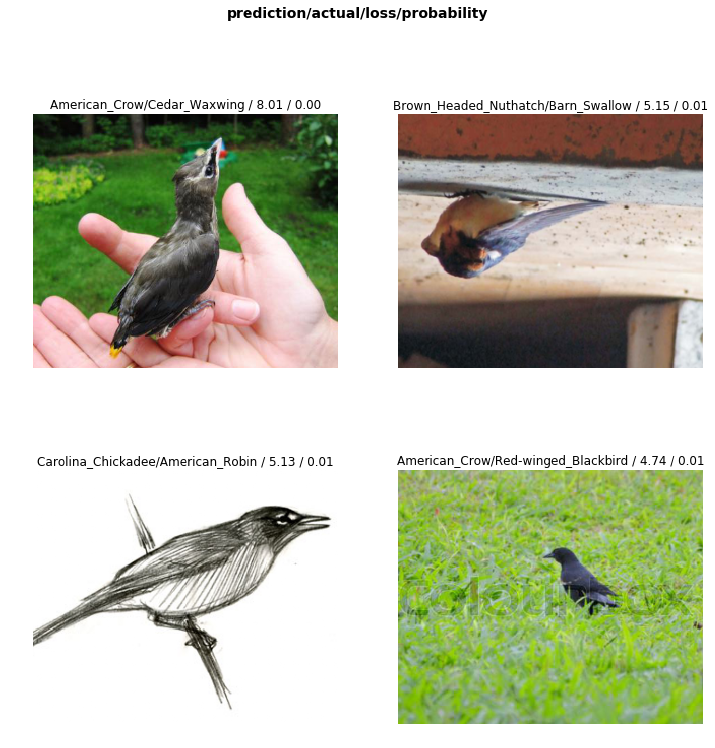

In [79]:
interp2 = ClassificationInterpretation.from_learner(learn)
interp2.plot_top_losses(4)

Still having trouble on 3 of the same photos, and the new one is quite understandable to a typical human-non-expert.

In [ ]:
@app.route("/classify-url", methods=["GET"])
async def classify_url(request):
    bytes = await get_bytes(request.query_params["url"])
    img = open_image(BytesIO(bytes))
    _,_,losses = learner.predict(img)
    return JSONResponse({
        "predictions": sorted(
            zip(cat_learner.data.classes, map(float, losses)),
            key=lambda p: p[1],
            reverse=True
        )
    })